# Import modules

In [1]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import ast
import json

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import *
from sklearn.metrics import *

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [2]:
# image_files = [x for x in glob.glob('images/*.jpg')]
# image_files_url = [x for x in glob.glob('images_url/*.jpg')]

# good_files = []

# for p in tqdm(image_files):
    
#     try:
#         _ = cv2.imread(p).copy()
#         good_files.append(p.split('.')[0].split('/')[-1])
        
#     except:
#         pass

# np.save('good_files', good_files)


# good_files_url = []

# for p in tqdm(image_files_url):
    
#     try:
#         _ = cv2.imread(p).copy()
#         good_files_url.append(p.split('.')[0].split('/')[-1])
        
#     except:
#         pass

# np.save('good_files_url', good_files_url)

In [3]:
good_files = list(np.load('good_files.npy'))
good_files_url = list(np.load('good_files_url.npy'))

In [4]:
train = pd.read_csv('train_processed.csv')
train_url = pd.read_csv('train_url_processed.csv')
test = pd.read_csv('test_processed.csv')

targets = train.typology.unique()
print(targets)
targets = [x.strip() for x in targets]
targets = np.array(targets)

train_url = train_url[train_url.typology.isin(targets)].reset_index(drop=True)
train['label'] = train.typology.apply(lambda x: np.where(targets == x)[0][0])
train_url['label'] = train_url.typology.apply(lambda x: np.where(targets == x)[0][0])

print('train shape:', train.shape)
print('train_url shape:', train_url.shape)
print('test shape:', test.shape)

['предметы нумизматики' 'редкие книги' 'документы' 'предметы археологии'
 'графика' 'предметы прикладного искусства, быта и этнографии'
 'предметы техники' 'живопись' 'фотографии и негативы'
 'предметы печатной продукции' 'предметы минералогической коллекции'
 'предметы естественнонаучной коллекции' 'прочие' 'скульптура' 'оружие']
train shape: (4735, 4)
train_url shape: (197116, 5)
test shape: (1223, 3)


In [73]:
sub = pd.read_csv('sample_submission.csv')

In [5]:
data = pd.read_csv('data_processed.csv')
data = data[data.typology.isin(targets)].reset_index(drop=True)
data['label'] = data.typology.apply(lambda x: np.where(targets == x)[0][0])
data.shape

(13276794, 6)

In [6]:
# temp = data[data.description.notnull()].groupby('description').typology.nunique().sort_values()

# # это классифицируется по изображением
# nndesc = temp[temp > 1].reset_index().description.unique()
# # остальное скармливается в фасттекст

# print(len(nndesc))

# np.save('nndesc', nndesc)

In [7]:
nndesc = list(np.load('nndesc.npy', allow_pickle=True))
print(len(nndesc))

130478


# Fasttext

In [8]:
import fasttext
import fasttext.util

In [9]:
train_text = data[(~data.description.isin(nndesc))&(~data.description.isin(test.description))].copy()
train_text = train_text.reset_index(drop=True)

In [10]:
test_text = test[((~test.description.isin(nndesc))|(~test.guid.isin(good_files)))
                 &(test.description.notnull())].copy()

In [11]:
test_text = pd.merge(test_text, data[~data.description.isin(nndesc)], on=['description'], 
                     how='left').reset_index(drop=True)

In [20]:
text_train, text_val = train_test_split(train_text, test_size=0.2, stratify=train_text.label)

In [55]:
os.remove('train.txt')
os.remove('valid.txt')

file = open('train.txt', 'w+')
fileval = open('valid.txt', 'w+')

for i in tqdm(range(text_train.shape[0])):
    
    x = text_train.iloc[i].values
    
    s = '__label__'
    s += str(x[5]) + ' '
    
    if type(x[0]) == str:
        s += x[0] + ' '
    if type(x[1]) == str:
        s += x[1] + ' '
    if type(x[2]) == str:
        s += x[2]
        
    file.write(s+'\n')
    
    
for i in tqdm(range(text_val.shape[0])):
    
    x = val_text_best.iloc[i].values
    
    s = '__label__'
    s += str(x[5]) + ' '
    
    if type(x[0]) == str:
        s += x[0] + ' '
    if type(x[1]) == str:
        s += x[1] + ' '
    if type(x[2]) == str:
        s += x[2]
        
    fileval.write(s+'\n')

100%|██████████| 534/534 [00:00<00:00, 25459.90it/s]


In [50]:
model = fasttext.train_supervised(input='train_best.txt', epoch=10, lr=0.5, wordNgrams=3)

In [65]:
model.save_model('ft_model.bin')

In [66]:
model = fasttext.load_model('ft_model.bin')

In [67]:
text_preds = []

for i in tqdm(range(test_text.shape[0])):
    
    x = test_text.iloc[i].values
    
    s = ''
    
    if type(x[1]) == str:
        s += x[1] + ' '
    if type(x[3]) == str:
        s += x[3] + ' '
    if type(x[4]) == str:
        s += x[4]
        
    tpred = model.predict(s)
    tpred = int(tpred[0][0].split('__')[-1])
    text_preds.append(targets[tpred])

len(text_preds)

100%|██████████| 560/560 [00:00<00:00, 6807.42it/s]


560

In [68]:
test_text['typology'] = text_preds

In [74]:
sub.loc[sub.guid.isin(test_text.guid), 'typology'] = text_preds

# Similar

In [75]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.models import Model
import numpy as np

def augment_fimage(image):
    aug = A.Compose([  
        A.RandomSizedCrop(min_max_height=[400, 440], height=456, width=456, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.FancyPCA(p=0.5),
    ])
    augmented = aug(image=image)
    return augmented['image'] 

class FeatureExtractor:
    
    def __init__(self):
        # Use EfficientNetB5 as the architecture and ImageNet for the weight
        base_model = EfficientNetB5(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
    
    def extract(self, path):
        img = cv2.imread(path)
        img = cv2.resize(img, (456, 456))
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)
    
    def extract_image(self, img):
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [76]:
train_nn = train[train.guid.isin(good_files)].copy()
train_url_nn = train_url[train_url.guid.isin(good_files_url)].copy()
test_nn = test[((test.guid.isin(good_files))&(test.description.isin(nndesc)))|(test.description.isnull())].copy()

print('train shape:', train_nn.shape)
print('train_url shape:', train_url_nn.shape)
print('test shape:', test_nn.shape)

train_nn['path'] = train_nn.guid.apply(lambda x: 'images/'+x+'.jpg')
train_url_nn['path'] = train_url_nn.guid.apply(lambda x: 'images_url/'+x+'.jpg')
test_nn['path'] = test_nn.guid.apply(lambda x: 'images/'+x+'.jpg')

train_nn = pd.concat([train_nn, train_url_nn], ignore_index=True)
print(train_nn.shape)

train shape: (4348, 4)
train_url shape: (165301, 5)
test shape: (663, 3)
(169649, 6)


In [77]:
# fe = FeatureExtractor()

# train_features = []

# for p in tqdm(train_nn.path):

#     train_features.append(fe.extract(p))

In [78]:
# np.save('train_features', np.array(train_features))

In [79]:
train_features = np.load('train_features.npy')

In [80]:
print(train_nn.shape)
train_features.shape

(169649, 6)


(116929, 2048)

In [81]:
df = pd.DataFrame()
df['description'] = train_nn.description[:len(train_features)]
df['typology'] = train_nn.typology.iloc[:len(train_features)]
df['path'] = train_nn.path.iloc[:len(train_features)]

In [82]:
def eucledian_distance(x, y):
    eucl_dist = np.linalg.norm(x - y)
    return eucl_dist

In [89]:
def find_nearest(img, trfs, q, df, max_typ):
    
    tfs = fe.extract_image(img)
    
    dists = []
    for i in range(len(trfs)):
        dists.append(eucledian_distance(tfs, trfs[i]))

    df['dist'] = dists

    imgs = [cv2.imread(df.sort_values('dist').path.iloc[i]) for i in range(15)]
    typs = [df.sort_values('dist').typology.iloc[i] for i in range(15)]
    
    return imgs, typs, df.sort_values('dist').iloc[:10].groupby('typology').dist.count().sort_values(ascending=False)

In [90]:
def show_nearest(img, max_typ, max_count, imgs, typs):
    
    _, ax = plt.subplots(1, 16, figsize=(35, 5))
            
    ax[0].imshow(img)
    ax[0].set_title(max_typ + '\n' + str(max_count))
    
    for i in range(15):
    
        ax[i+1].imshow(imgs[i])
        ax[i+1].set_title(typs[i])
    
    plt.show()

In [91]:
def augment_fimage_hand(image, q):
    
    if q in [4, 69]:
        aug = A.Compose([A.Rotate(limit=[88, 92], p=1)])
    elif q == 12:
        aug = A.Compose([A.ToGray(p=1)])
    else:
        aug = A.Compose([A.FancyPCA(p=0)])

    return cv2.resize(aug(image=image)['image'] , (456, 456))

In [92]:
fe = FeatureExtractor()

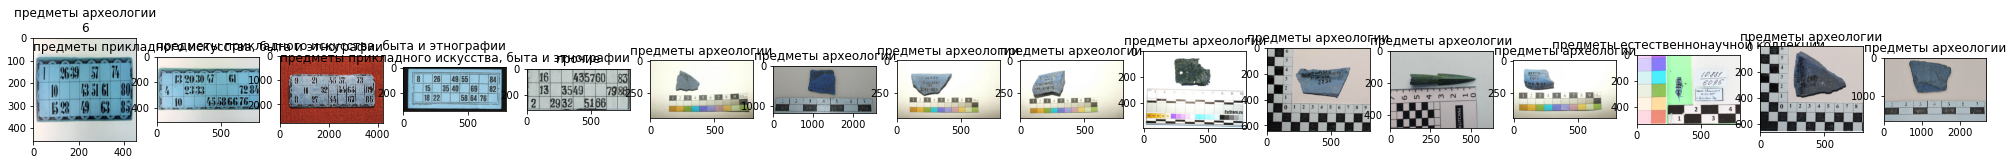

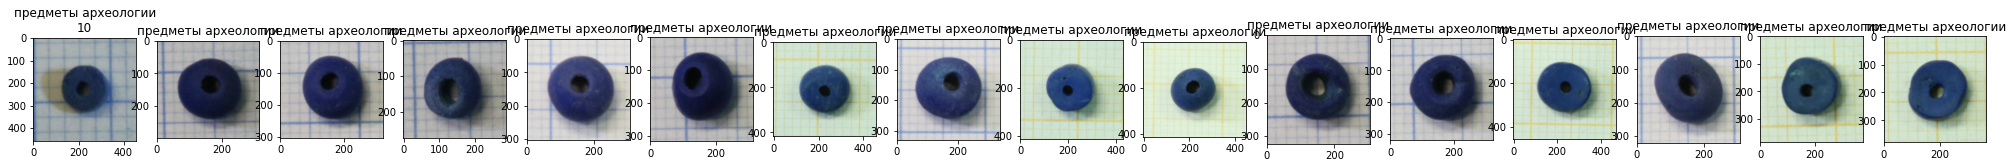

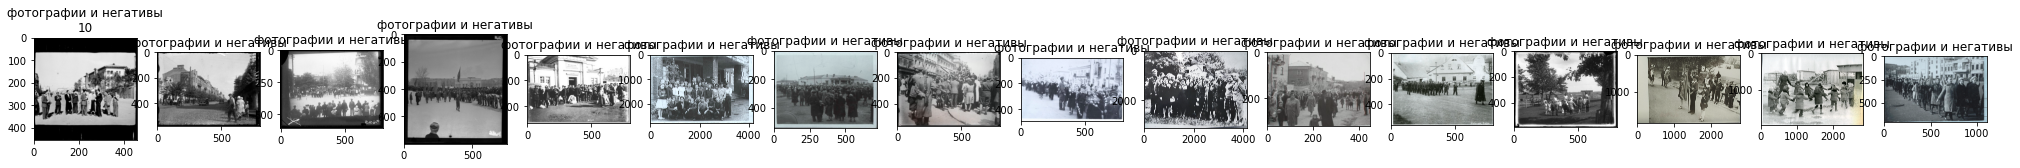

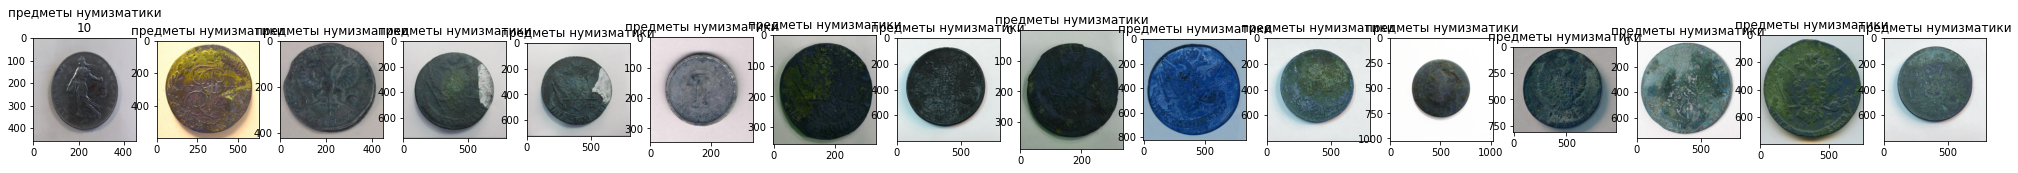

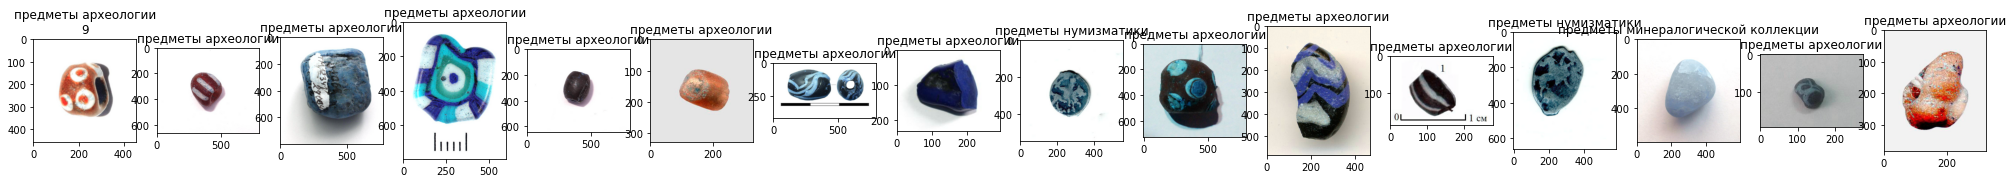

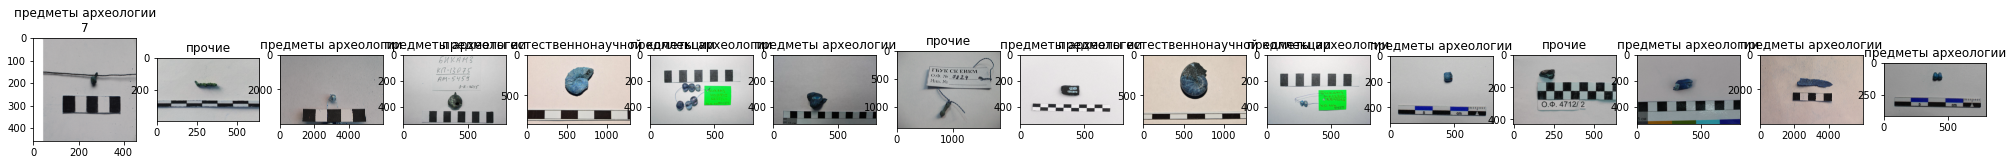

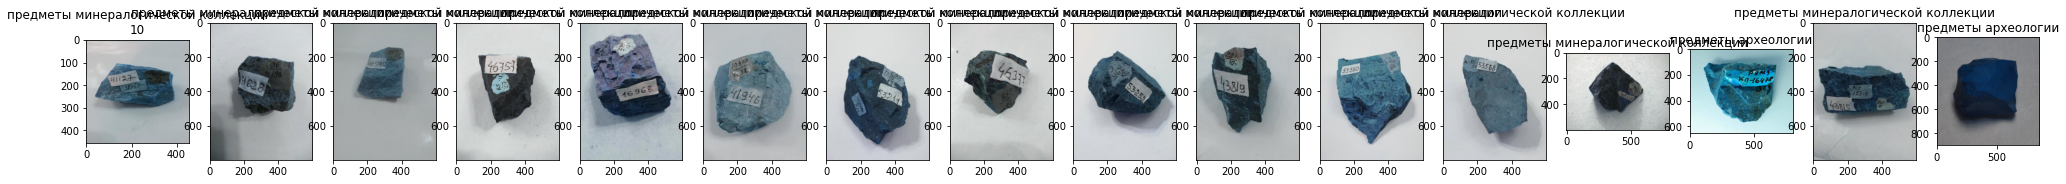

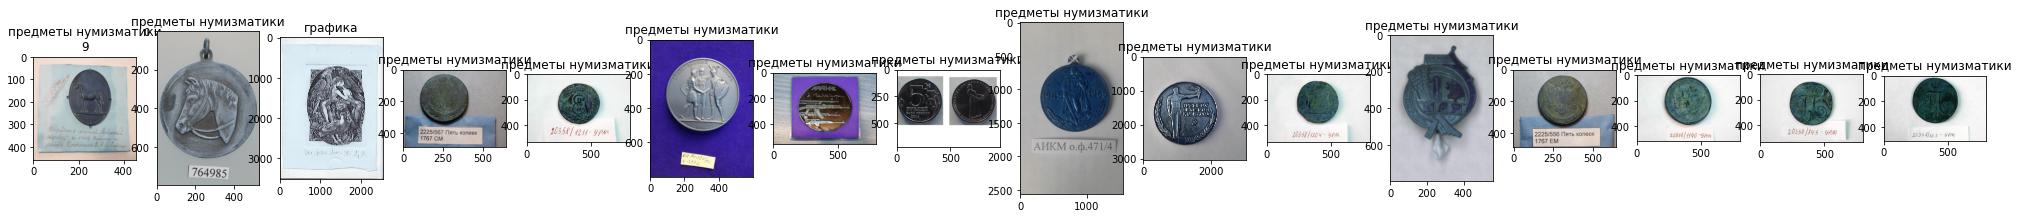

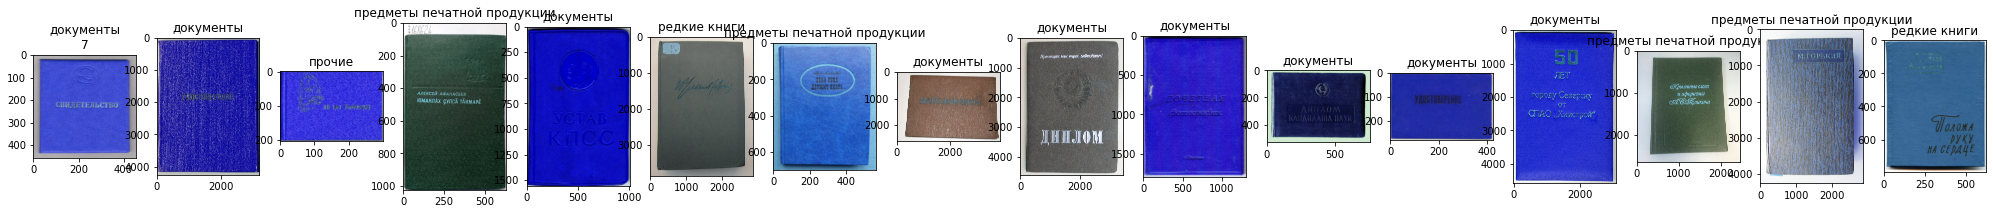

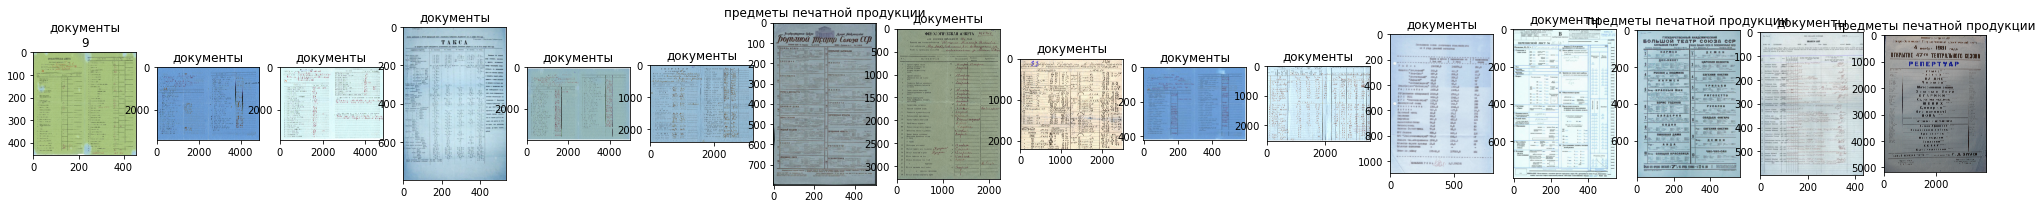

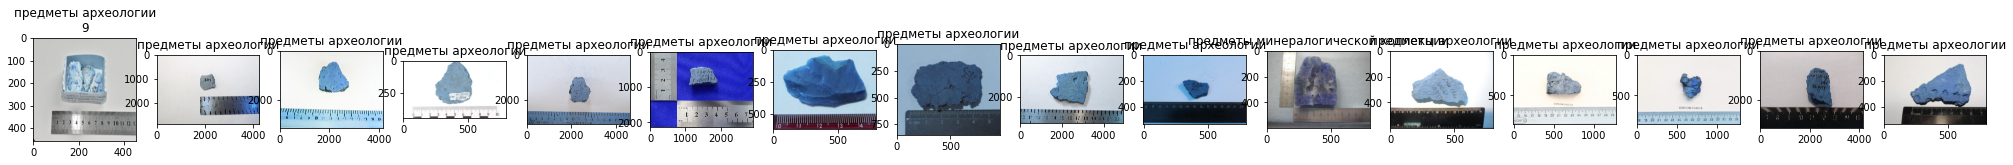

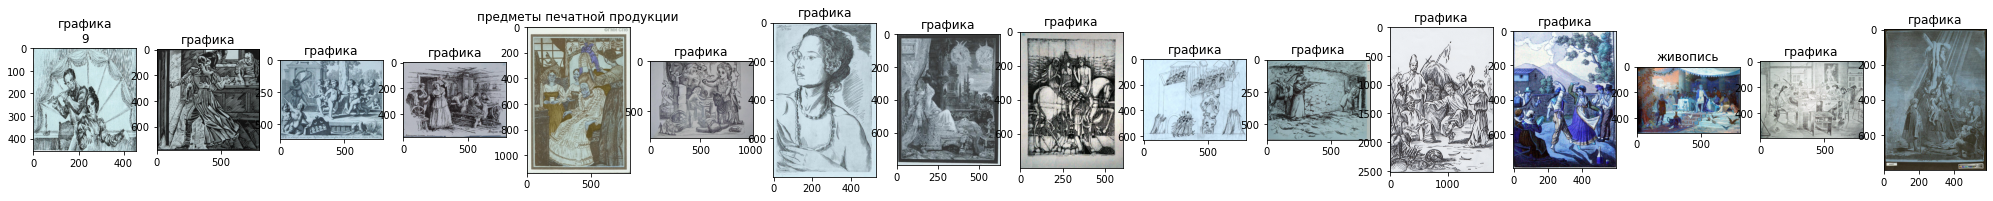

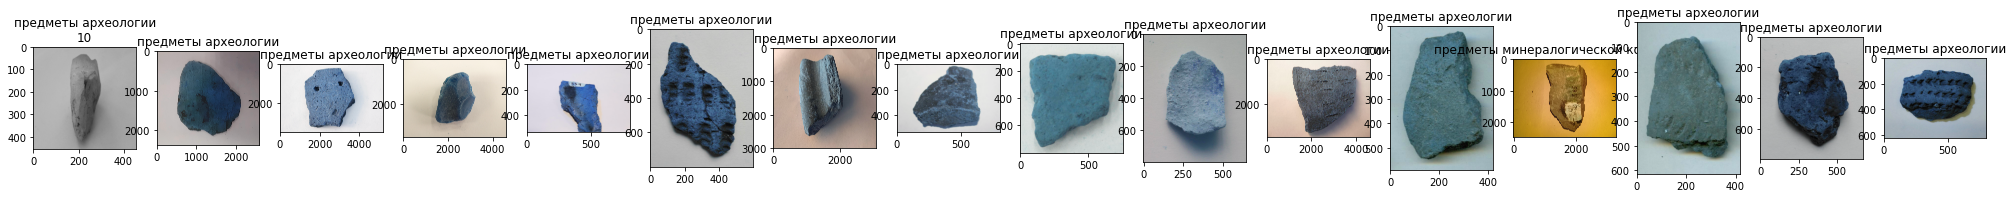

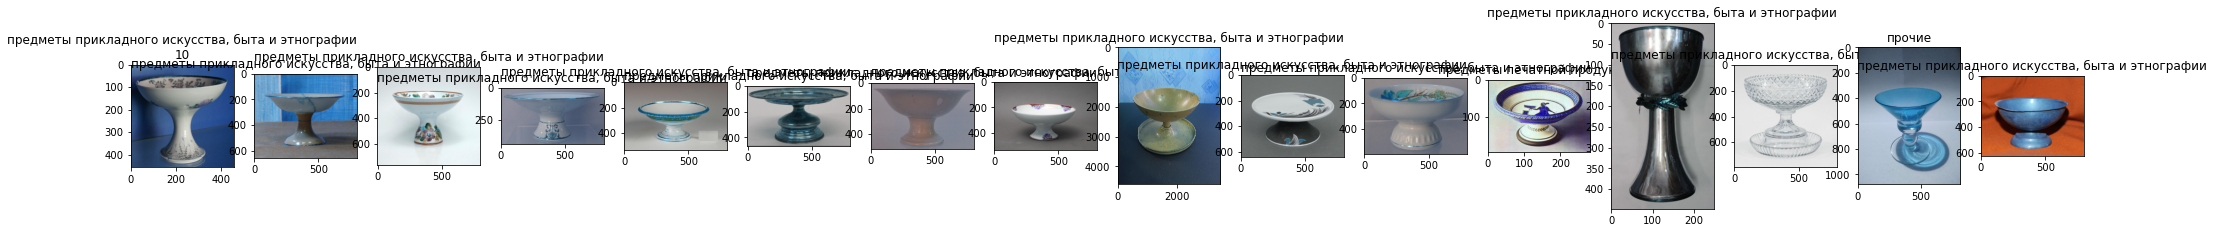

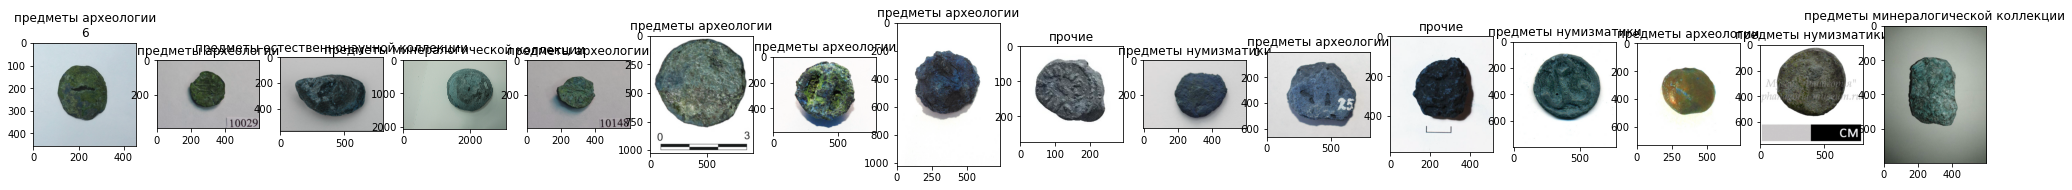

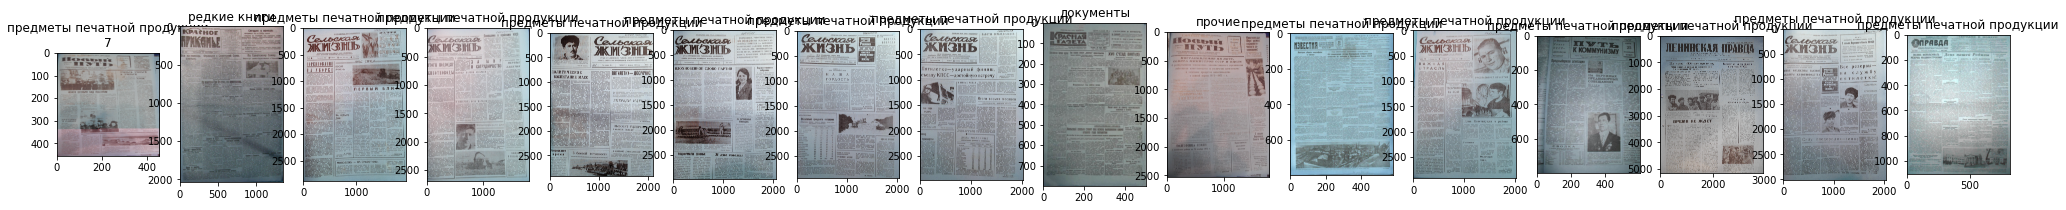

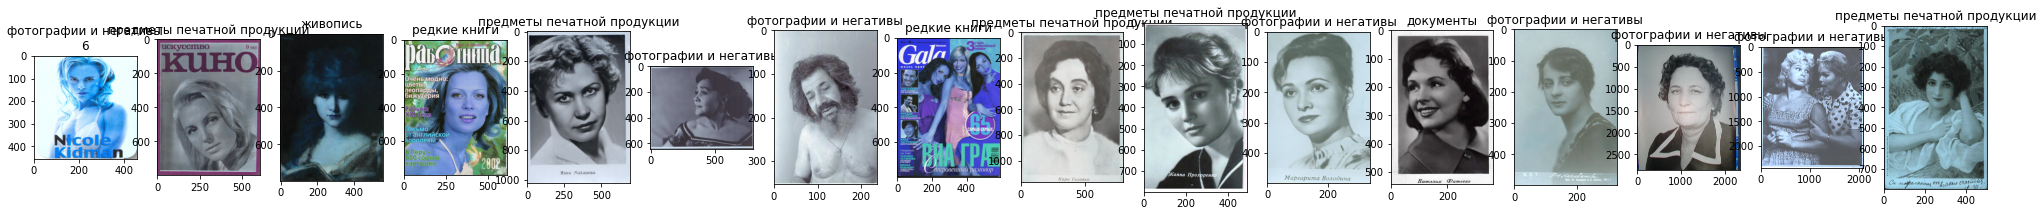

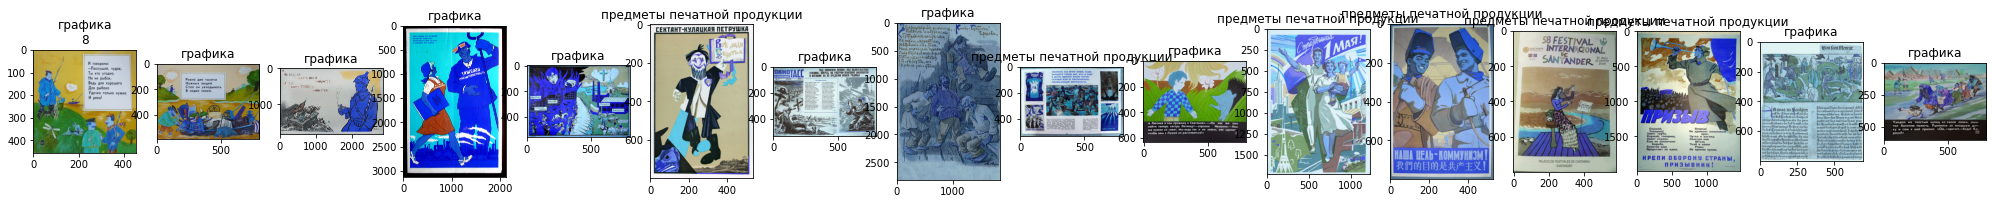

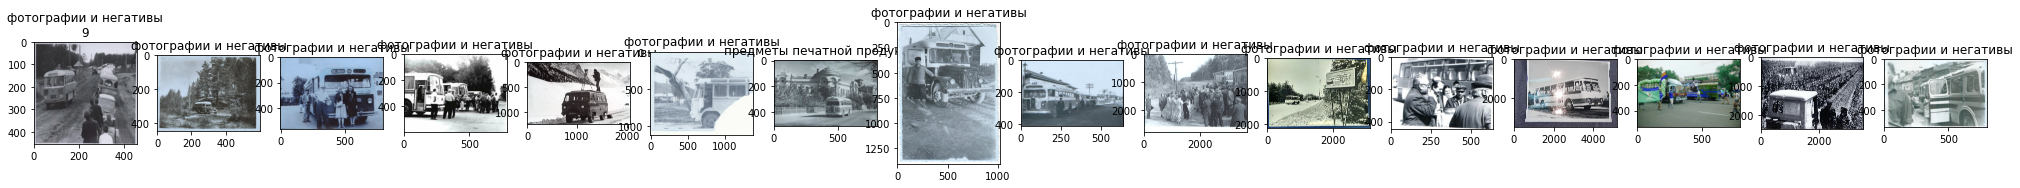

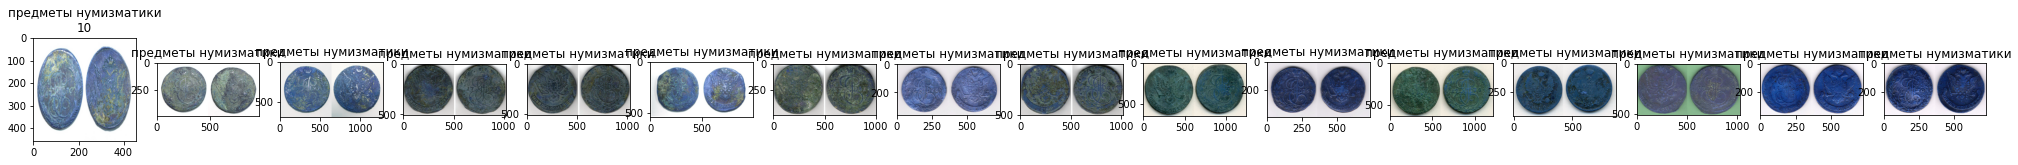

In [93]:
test_sample = test_nn.sample(20)

for q in range(test_sample.shape[0]):
    
    max_typ = ''
    max_count = 0

    img = cv2.imread(test_sample.path.iloc[q]).copy()
    img = cv2.resize(img, (456, 456))
    
    img = augment_fimage_hand(img, q)
    
    imgs, typs, tdict = find_nearest(img, train_features, q, df, max_typ)
    
    if tdict.iloc[0] > max_count:
        max_count = tdict.iloc[0]
        max_typ = tdict.index[0]
    
    if max_count > 8:
        pass
        
    else:
        for i in range(10):
            
            if max_count > 8:
                break
                
            aug_img = augment_fimage(img)
            
            imgs, typs, tdict = find_nearest(aug_img, train_features, q, df, max_typ)
            
            if tdict.iloc[0] > max_count:
                max_count = tdict.iloc[0]
                max_typ = tdict.index[0]

    show_nearest(img, max_typ, max_count, imgs, typs)

In [76]:
sim_labels = []

for q in tqdm(range(test_nn.shape[0])):
    
    max_typ = ''
    max_count = 0

    img = cv2.imread(test_nn.path.iloc[q]).copy()
    img = cv2.resize(img, (456, 456))
    
    img = augment_fimage_hand(img, q)
    
    imgs, typs, tdict = find_nearest(img, train_features, q, df, max_typ)
    
    if tdict.iloc[0] > max_count:
        max_count = tdict.iloc[0]
        max_typ = tdict.index[0]
    
#     show_nearest(img, max_typ, max_count, imgs, typs)
    
    if max_count > 4:
        pass
        
    else:
        for i in range(10):
            
            if max_count > 4:
                break
                
            aug_img = augment_fimage(img)
            
            imgs, typs, tdict = find_nearest(aug_img, train_features, q, df, max_typ)
            
            if tdict.iloc[0] > max_count:
                max_count = tdict.iloc[0]
                max_typ = tdict.index[0]

#             show_nearest(img, max_typ, max_count, imgs, typs)

#     show_nearest(img, max_typ, max_count, imgs, typs)
        
    sim_labels.append(max_typ)

100%|██████████| 663/663 [48:00<00:00,  4.35s/it]  


In [77]:
len(sim_labels)

663

In [79]:
sub.loc[sub.guid.isin(test_nn.guid), 'typology'] = sim_labels

In [81]:
# sub.to_csv('sub_ftsim_2.csv', index=False)

# Load images url

In [1]:
from PIL import Image
import requests
import pandas as pd
import glob
from tqdm import tqdm

In [2]:
exist_files = [file.split('/')[-1].split('.')[0] for file in glob.glob('images_url/*.jpg')]

In [3]:
train_url_load = pd.read_csv('train_url_only.csv')
train_url_load = train_url_load[train_url_load.url.notnull()]
train_url_load = train_url_load[~train_url_load.guid.isin(exist_files)].reset_index(drop=True)

In [6]:
for url, guid in tqdm(zip(train_url_load.url, train_url_load.guid)):

    try:
        img = Image.open(requests.get(url, stream=True).raw)
        img.save('images_url/{}.jpg'.format(guid))
    
    except:
        pass

15603it [18:23, 14.14it/s] 
